# Introduction

Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas.

# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). 

The file "sign_mnist_train.csv" contains 27,455 training examples and the file "sign_mnist_test.csv" contains 7172 testing examples. This dataset has approximately half the size of the original MNIST image dataset of handwritten digits, but it is otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

In [2]:
train = pd.read_csv('sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test/sign_mnist_test.csv')

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


A couple of things to keep in mind:

1. The first line contains the column headers, so we should ignore it.
2. Each successive line contains 785 comma-separated values between 0 and 255
2.1. The first value is the label
2.2. The rest are the pixel values for that picture

We perform a grayscale normalization to reduce the effect of illumination's differences.
Moreover the NN converges faster on [0..1] data than on [0..255].

In [38]:
# Training images
X = np.array(train.drop(columns='label')).astype(float)

# Training labels
y = np.array(train['label']).astype(float)
y = y.reshape(len(y), 1)

# Number of training examples
m = len(y)

print(y.shape)
print(X.shape)
print("Number of training examples:", m)

# Normalize the data
X = X / 255


(27455, 1)
(27455, 784)
Number of training examples: 27455


### View Data

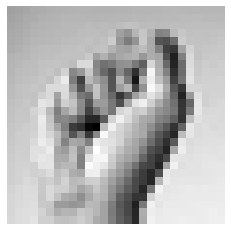

In [68]:
r = np.random.randint(0,27455)

if (r >= 0 and r < 27455):
    img = X[r].reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()  

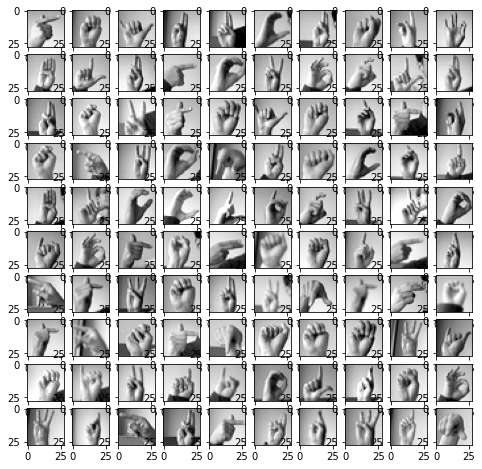

In [67]:
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        # Reshape back to 20x20 pixel image
        axis[i,j].imshow(X[np.random.randint(0,27455),:].reshape((28, 28)), cmap="gray") 

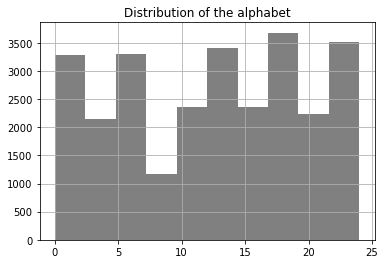

In [7]:
train.label.hist(color='grey',bins=10)
plt.title("Distribution of the alphabet")
plt.show()

# Computing the Cost Function

In [33]:
# Return the sigmoid of z
def sigmoid(z):
    gz=1/(1+np.exp(-z))
    return gz

In [9]:
# Return the regularized cost function and gradients of the logistic regression classifier
def costFunctionReg(X, y, theta, Lambda):   
    
    # Number of training examples 
    m = len(y)
        
    # Vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X,theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    # Cost function without regularization term
    cost = sum(error)/m
    
    # Add regularization term to the cost function (L2 norm)
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # Gradient of theta_0
    grad_0 = (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    # Vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # All gradients in a column vector shape
    grad_all = np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [10]:
# Update theta by taking num_iters gradient steps with learning rate of alpha
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    
    J_history =[]
    for i in range(num_iters):
        
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        theta = theta-alpha*grad
        
        J_history.append(cost)
    
    return theta , J_history

# One-vs-all Classification

Here we implement one-vs-all classification by training multiple Regularized Logistic Regression classifiers, one for each of the K = 25 classes in the MNIST dataset.

In [41]:
# Train K Logistic Regression classifiers using gradient descent
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K):
    
    all_theta = []
    all_J=[]
    
    # Number of training examples
    m = len(y)
    
    # Number of features
    n = X.shape[1]
    
    # Add an extra column of 1´s corresponding to xo=1 (dummy feature)
    X = np.append(np.ones((m,1)), X, axis=1)
    
    for i in range(1,K+1):
            
        theta , J_history = gradientDescent(X,np.where(y==i,1,0), initial_theta, alpha, num_iters, Lambda)
        
        # Add the vector of optimized parameters theta of classifier i
        all_theta.extend(theta)
                
        # add the cost function history of classifier i
        all_J.extend(J_history)
        
    # Return all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    # and all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    return np.array(all_theta).reshape(K,n+1), all_J

In [52]:
# Inicialize vector theta = 0
initial_theta = np.zeros((X.shape[1]+1,1))

# Optimization hyper-parameters 
alpha = 1 # Learning rate
num_iters = 100
Lambda = 0.1

all_theta, all_J = oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, 25)

print(np.size(all_theta))
print(all_theta.shape)

19625
(25, 785)


### Plot the Cost Functions for all (K = 25) classifiers 

Text(0.5, 1.0, 'Cost function using Gradient Descent')

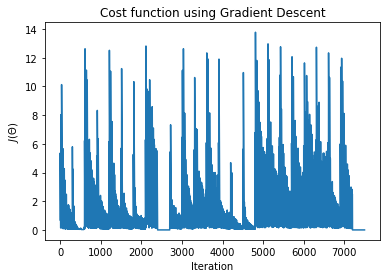

In [47]:
plt.plot(all_J)  # All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

### One-vs-all Prediction

In [53]:
# Compute the probability of image X(i) for each class and predict the label
def predictOneVsAll(all_theta, X):

    # Number of training examples
    m = X.shape[0]

    # Add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)), X, 1)
    
    predictions = np.dot(X, all_theta.T)
    
    # np.argmax returns indices of the max element of the array in a particular axis
    return np.argmax(predictions, axis=1)

In [54]:
pred = predictOneVsAll(all_theta, X)
pred = pred.reshape((pred.shape[0],1)) 

print("Training Set Accuracy:",sum(pred==y)[0]/m*100,"%")

Training Set Accuracy: 4.199599344381715 %


# Shallow Neural Network

Objectives: Implement Backpropagation algorithm for NN training to the task of sign language recognition.

NN cost function: 
 
(...)

nnCostFunction computes the NN cost (above) and the gradients with and without regularization.

In [55]:
# Compute the cost and gradient of the neural network
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):

    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:]
        a1i = a1[i,:]
        a2i =a2[i,:]
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [56]:
# Computes the gradient of sigmoid function
def sigmoidGradient(z):
    sigmoid = 1/(1 + np.exp(-z))
    return sigmoid *(1-sigmoid) 

### Random initialization

Select values for  uniformly in the range (...).

One effective strategy for choosing  is to base it on the number of units in the network.

(...)

In [57]:
# Randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
def randInitializeWeights(L_in, L_out):

    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [58]:
input_layer_size  = 784
hidden_layer_size = 25
num_labels = 25

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

### Gradient Descent (input-layer => ONE hidden layer => output layer)

In [59]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [61]:
alpha=1 #learning rate
num_iters=100
Lambda=0.1
num_labels = 25

nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [63]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
        #number of training examples
    m=X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)),X,1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1=sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T) #Inputs to the output layer neurons
    a2=sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)+1

In [64]:
pred3 = predict(Theta1, Theta2, X)

print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/m*100,"%")

Training Set Accuracy: 7.375705700236751 %


Text(0.5, 1.0, 'Cost function using Gradient Descent')

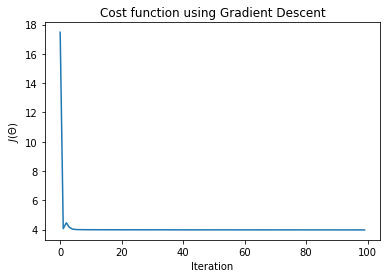

In [65]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

# Convolutional Neural Network

A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.